In [1]:
import pandas as pd
from pathlib import Path
from tennis_new.fetch.defs import STORED_DATA_PATH

jd = pd.read_csv(
    Path.joinpath(STORED_DATA_PATH, 'joined.tsv'),
    sep='\t'
)

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10,11,14,33,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
jd['tourney_surface'].value_counts()

Hard      76802
Clay      65213
Grass     38456
Carpet    17635
Name: tourney_surface, dtype: int64

In [27]:
# We should know surface for all matches
assert jd['tourney_surface'].notnull().all()

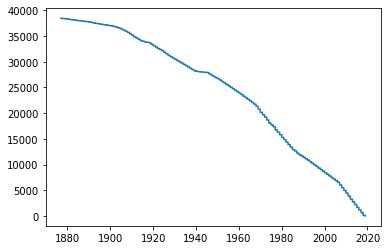

In [29]:
# How much grass data do we have over time?
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(
    jd['tourney_year'],
    (jd['tourney_surface'] == 'Grass').sum() - (jd['tourney_surface'] == 'Grass').cumsum()
)

In [69]:
# Say we want 5k grass test set matches, let's get these...
TEST_SIZE = 5000

def get_val_test_for_surface(df, surface='Grass', n=5000):
    total_on_surface = (df['tourney_surface'] == surface).sum()
    n_test_on_surface = total_on_surface - (df['tourney_surface'] == surface).cumsum()
    val_idx = np.where(
        (n_test_on_surface <= 2 * n) &
        (n_test_on_surface > n) &
        (df['tourney_surface'] == surface)
    )[0]
    test_idx = np.where(
        (n_test_on_surface <= n) &
        (df['tourney_surface'] == surface)
    )[0]
    return val_idx, test_idx 

In [70]:
val_idx, test_idx = get_val_test_for_surface(jd, surface='Grass')

In [71]:
len(val_idx), len(test_idx)

(5000, 5001)

In [72]:
jd[['tourney_year', 'tourney_month']].iloc[[val_idx.min(), test_idx.min()], :]

,tourney_year,tourney_month
108773,1995,6.0
155866,2009,7.0


My validation set begins in June 1995 and my test begins in July 2009

In [118]:
# Universal ELO Model
from tennis_new.ml.elo import ELOModel

elo = ELOModel(winner_mod=True)
elo.fit_and_backfill(
    jd['winner_name'].tolist(),
    jd['loser_name'].tolist(),
    jd['match_id'].tolist()
)

In [89]:
def _eval_mod(mod):
    history_df = pd.DataFrame(mod.history)
    val_accuracy = (history_df.iloc[val_idx]['elo_match_prediction'] > 0.5).mean()
    test_accuracy = (history_df.iloc[test_idx]['elo_match_prediction'] > 0.5).mean()
    return {
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy
    }

In [90]:
_eval_mod(elo)

{'val_accuracy': 0.6604, 'test_accuracy': 0.6600679864027195}

Without any surface weighting, we achieve 66% accuracy on both the val set and the test set.  Now let's try surface weighting... 

In [91]:
# Sobol functions... 
# TODO: These should be in the repo
from sobol import i4_sobol

def generate_sobol_seq(dim, n, seed):
    seed = seed
    out = []
    for i in range(n):
        cur_out, seed = i4_sobol(dim, seed)
        out.append(cur_out)
    return np.array(out)

def get_range_params(mini, maxi, randos):
    return np.array(
        list(map(lambda x: x * (maxi - mini) + mini, randos))
    )

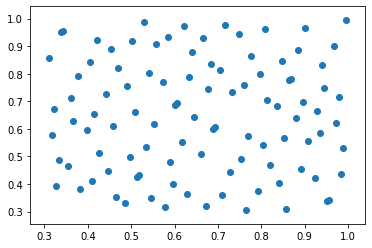

In [112]:
# Sobol Sample for Hyperparams, tune universal ELO model
from tennis_new.ml.elo import ELOModel

N_MODELS = 100
SEED = 10
MIN_WEIGHT = 0.3
MAX_WEIGHT = 1.

sobol_grid = generate_sobol_seq(3, N_MODELS, SEED)
clay_weights = get_range_params(MIN_WEIGHT, MAX_WEIGHT, sobol_grid[:, 0])
hard_weights = get_range_params(MIN_WEIGHT, MAX_WEIGHT, sobol_grid[:, 1])
carpet_weights = get_range_params(MIN_WEIGHT, MAX_WEIGHT, sobol_grid[:, 2])

plt.scatter(clay_weights, hard_weights)

In [114]:
# Tune over surface weights
from tqdm import tqdm

out = []
for clay, hard, carpet in tqdm(zip(clay_weights, hard_weights, carpet_weights)):
    weight_dict = {
        'Clay': clay,
        'Hard': hard,
        'Carpet': carpet,
        'Grass': 1.0
    }
    weights = jd['tourney_surface'].map(lambda x: weight_dict[x])
    cur_elo = ELOModel(winner_mod=True)
    cur_elo.fit_and_backfill(
        jd['winner_name'].tolist(),
        jd['loser_name'].tolist(),
        jd['match_id'].tolist(),
        weights=weights
    )
    cur_eval = _eval_mod(cur_elo)
    cur_eval.update(weight_dict)
    out.append(cur_eval)

100it [02:07,  1.09s/it]


In [115]:
tune_df = pd.DataFrame(out)
tune_df.sort_values('val_accuracy', ascending=False).head(20)

,Carpet,Clay,Grass,Hard,test_accuracy,val_accuracy
69,0.830469,0.360156,1.0,0.710156,0.665267,0.6666
54,0.611719,0.316406,1.0,0.578906,0.663467,0.6664
21,0.584375,0.321875,1.0,0.671875,0.665467,0.6658
6,0.890625,0.365625,1.0,0.628125,0.664267,0.6654
86,0.950781,0.327344,1.0,0.392969,0.662667,0.6648
45,0.748437,0.442187,1.0,0.726562,0.665267,0.6648
34,0.595312,0.551562,1.0,0.617188,0.662667,0.6644
66,0.655469,0.535156,1.0,0.535156,0.657668,0.6640
37,0.420312,0.376562,1.0,0.792187,0.663667,0.6640
53,0.967187,0.310937,1.0,0.857812,0.664267,0.6638


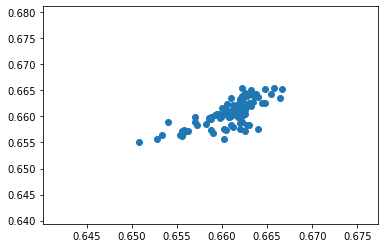

In [116]:
plt.scatter(tune_df['val_accuracy'], tune_df['test_accuracy'])

In [117]:
from scipy.stats import spearmanr

spearmanr(tune_df['val_accuracy'], tune_df['test_accuracy']).correlation

0.7093870733527099

Val performance and test performance are generally correlated...this is good!  Our results generalize!  We can get an extra half point of accuracy by just weighting the surfaces appropriately...We can take our optimal weights from above...